In [1]:
import sys
import torch
from detectron2.data import MetadataCatalog
from detectron2.data.detection_utils import read_image
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt

sys.path.append('..')
from src import load_config, load_model, get_model_list
from src.models.ovd.modeling.utils import reset_cls_test, dump_clip_embeddings

/home/ubuntu/anaconda3/envs/detector/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define vocabularies

In [2]:
# Modify the detectors vocabulary

# Choose from one of the provided set of vocabulary
BUILDIN_CLASSIFIER = {
    'lvis': '../src/models/ovd/zero_shot_weights/lvis_v1_clip_a+photo+cname.npy',
    'coco': '../src/models/ovd/zero_shot_weights/coco_clip_a+photo+cname.npy'
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'coco': 'coco_2017_val',
}

def show_results(image, meta, predictions):
    vis = Visualizer(image, meta)
    vis_output = vis.draw_instance_predictions(predictions["instances"])
    plt.figure(figsize=(15,15))
    plt.xticks([]), plt.yticks([])
    plt.imshow(vis_output.get_image())


# 1. Initialize model

In [37]:
VOCABULARY = 'coco'

# load config
cfg = load_config('../configs/COCO_OVD_RKD_PIS_WeightTransfer_8x.yaml')

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = BUILDIN_CLASSIFIER[VOCABULARY]
# load model weights
object_detector = load_model(cfg)
# init metadata with class names
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused")

The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.box_predictor.freq_weight


# 2. Get predictions with original settings

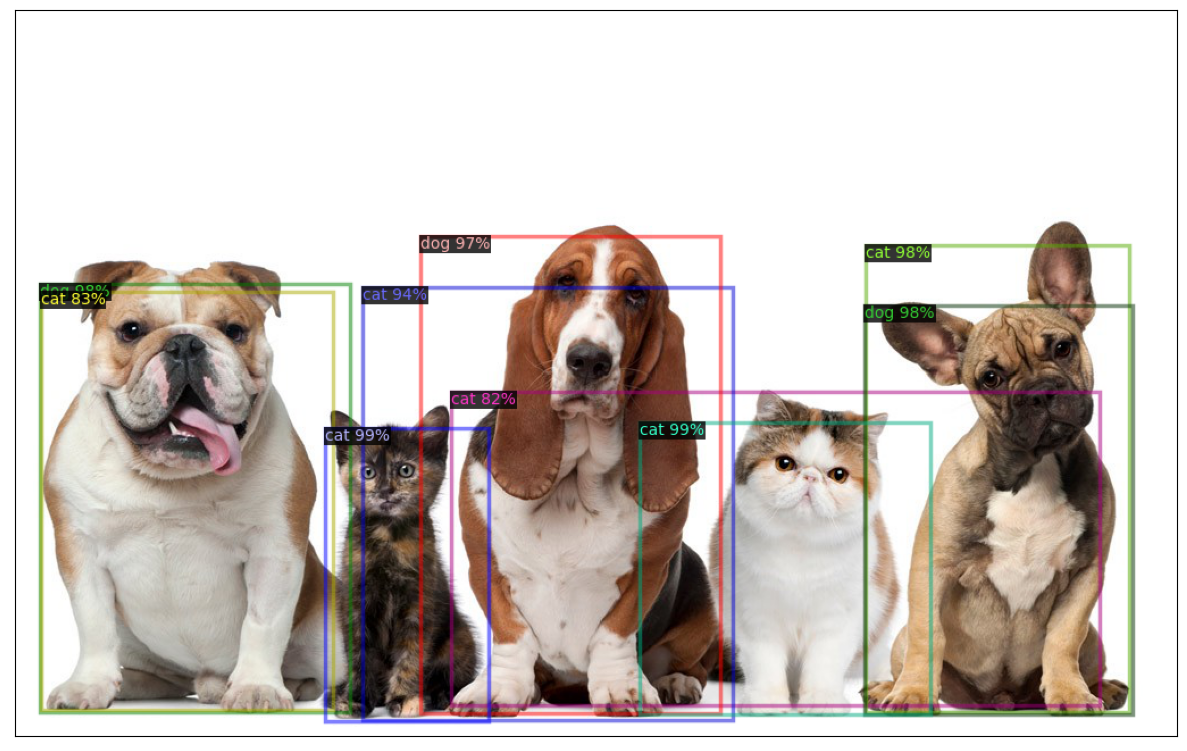

In [38]:
image_example = read_image('images/image_1.jpg')
predictions = object_detector([image_example])[-1]
show_results(image_example, metadata,predictions)

# 3. Change vocabulary

Resetting zs_weight ../src/models/ovd/zero_shot_weights/lvis_v1_clip_a+photo+cname.npy


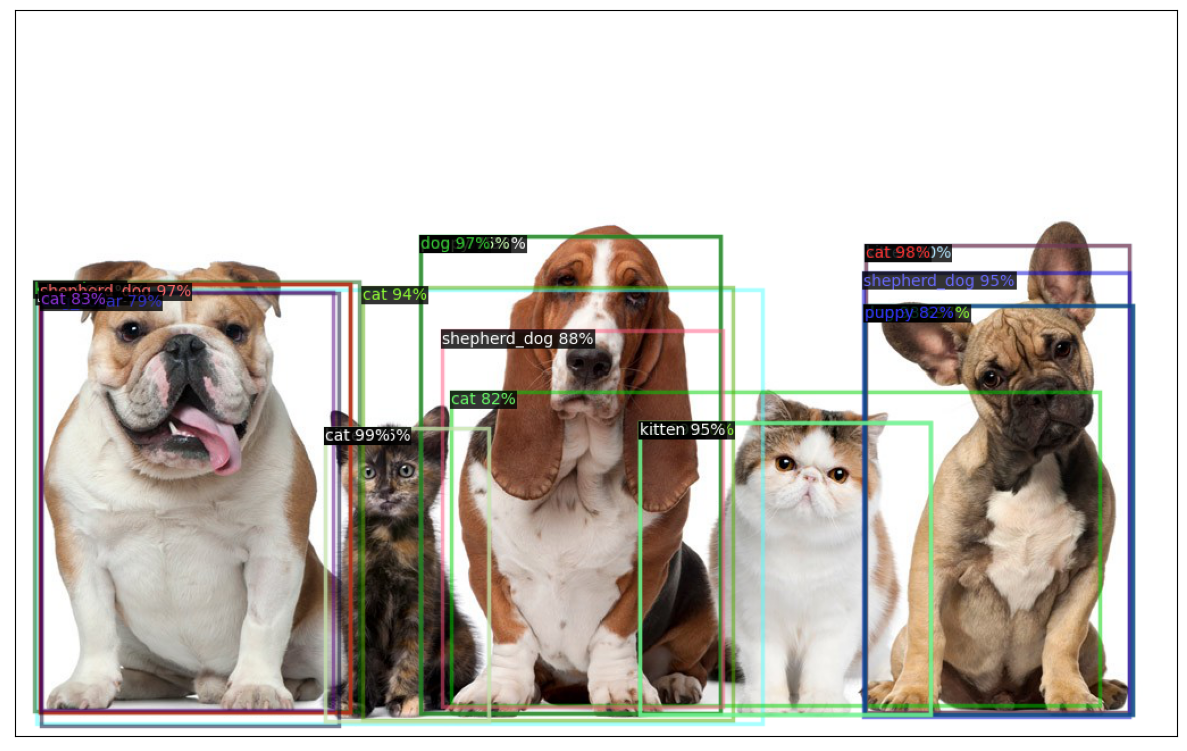

In [39]:
VOCABULARY = 'lvis'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[VOCABULARY])
classifier = BUILDIN_CLASSIFIER[VOCABULARY]
num_classes = len(metadata.thing_classes)

reset_cls_test(object_detector.model, classifier, num_classes)

predictions = object_detector([image_example])[-1]
show_results(image_example, metadata,predictions)

# 4. Define your own classes

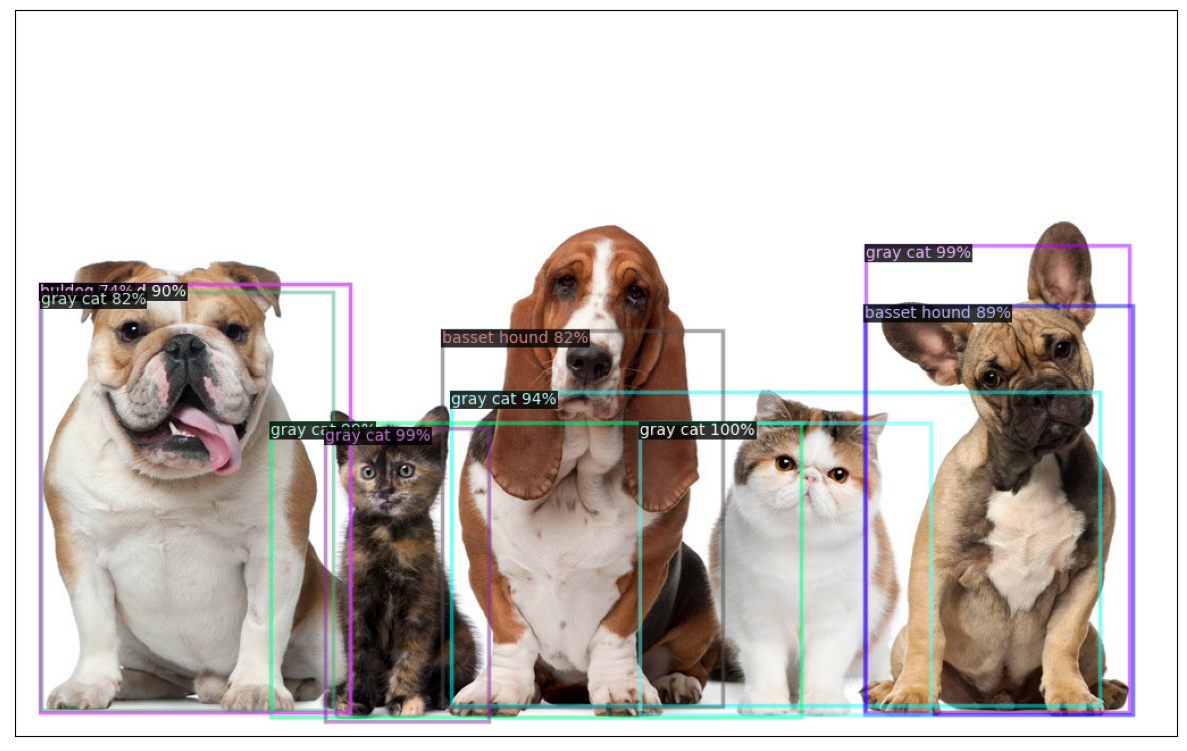

In [41]:
vocabulary = 'custom'
metadata = MetadataCatalog.get("new_classes")
if hasattr(metadata, "thing_classes"):
    del metadata.thing_classes
metadata.thing_classes = ['buldog', 'basset hound', 'gray cat'] # add rour own vocabulary for the detector
classifier = dump_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(object_detector.model, classifier, num_classes)


predictions = object_detector([image_example])[-1]
show_results(image_example, metadata,predictions)